Train DHG

In [14]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target (i + sequence_length)
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='GRU_DHG_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/GRU/GRU_DHG_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = GRUModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/DHG_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/GRU/GRU_DHG_Classification.pth')

Train size: 2636
Test size: 56
Class distribution in train set:
0    1578
1    1058
Name: count, dtype: int64
Class distribution in test set:
0    33
1    23
Name: count, dtype: int64
Epoch 1/100, Loss: 67.9977, Accuracy: 52.10%
Epoch 2/100, Loss: 68.3276, Accuracy: 43.79%
Epoch 3/100, Loss: 68.1310, Accuracy: 46.53%
Epoch 4/100, Loss: 68.0779, Accuracy: 50.30%
Epoch 5/100, Loss: 68.0642, Accuracy: 50.15%
Epoch 6/100, Loss: 68.0504, Accuracy: 50.53%
Epoch 7/100, Loss: 68.0399, Accuracy: 50.57%
Epoch 8/100, Loss: 68.0305, Accuracy: 50.80%
Epoch 9/100, Loss: 68.0184, Accuracy: 50.76%
Epoch 10/100, Loss: 67.9996, Accuracy: 50.84%
Epoch 11/100, Loss: 67.9694, Accuracy: 51.45%
Epoch 12/100, Loss: 67.9476, Accuracy: 51.79%
Epoch 13/100, Loss: 67.9357, Accuracy: 52.06%
Epoch 14/100, Loss: 67.9199, Accuracy: 52.29%
Epoch 15/100, Loss: 67.9043, Accuracy: 52.13%
Epoch 16/100, Loss: 67.8878, Accuracy: 50.76%
Epoch 17/100, Loss: 67.8663, Accuracy: 51.33%
Epoch 18/100, Loss: 67.8360, Accuracy: 51.3

Load DHG

Test size: 56
Class distribution in test set:
0    33
1    23
Name: count, dtype: int64
Model loaded from models/GRU/GRU_DHG_Classification.pth

Threshold: 0.5
Test Accuracy: 0.4091
Precision: 0.3846
Recall: 0.8824
F1-Score: 0.5357

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0      False
1  2025-01-21     1.0      False
2  2025-01-22     0.0       True
3  2025-01-23     1.0       True
4  2025-01-24     0.0       True
5  2025-02-03     1.0       True
6  2025-02-04     1.0       True
7  2025-02-05     1.0       True
8  2025-02-06     0.0      False
9  2025-02-07     0.0       True
10 2025-02-10     1.0      False
11 2025-02-11     0.0       True
12 2025-02-13     1.0       True
13 2025-02-14     0.0       True
14 2025-02-17     1.0       True
15 2025-02-18     0.0       True
16 2025-02-19     1.0       True
17 2025-02-20     0.0       True
18 2025-02-21     1.0       True
19 2025-02-24     0.0       True
20 2025-02-25     1.0       True
21 

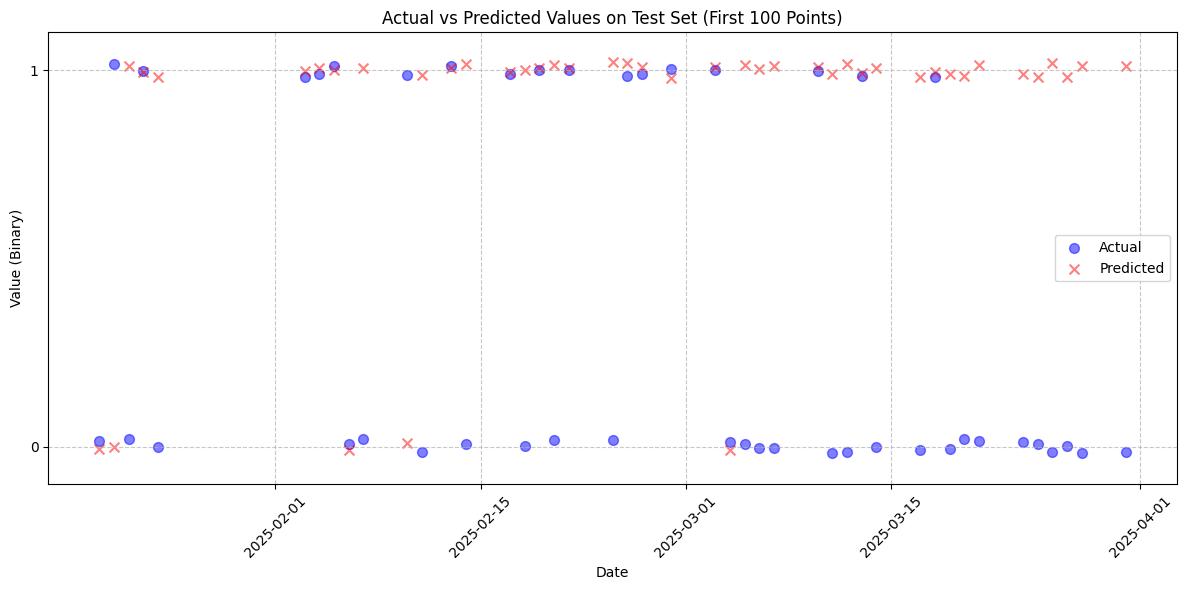

In [15]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import os

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/GRU/GRU_DHG_Classification.pth'):
    model = GRUModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    threshold = 0.5
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()

# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/GRU/GRU_DHG_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    # Plot predictions vs actual values
    plot_predictions(predictions, labels, test_dates, max_points=100)

# Run the script
if __name__ == "__main__":
    file_path = "data/DHG_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/GRU/GRU_DHG_Classification.pth')
    
    
# Threshold: 0.5
# Test Accuracy: 0.4091
# Precision: 0.3784
# Recall: 0.8235
# F1-Score: 0.5185

# Threshold: 0.55
# Test Accuracy: 0.4318
# Precision: 0.3824
# Recall: 0.7647
# F1-Score: 0.5098

# Threshold: 0.5
# Test Accuracy: 0.4091
# Precision: 0.3846
# Recall: 0.8824
# F1-Score: 0.5357

TRA Train

In [16]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target (i + sequence_length)
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='models/GRU/GRU_TRA_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/GRU/GRU_TRA_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = GRUModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/TRA_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/GRU/GRU_TRA_Classification.pth')

Train size: 2634
Test size: 56
Class distribution in train set:
0    1672
1     962
Name: count, dtype: int64
Class distribution in test set:
0    37
1    19
Name: count, dtype: int64
Epoch 1/100, Loss: 72.4154, Accuracy: 52.71%
Epoch 2/100, Loss: 72.7184, Accuracy: 48.97%
Epoch 3/100, Loss: 72.4662, Accuracy: 48.86%
Epoch 4/100, Loss: 72.3296, Accuracy: 50.19%
Epoch 5/100, Loss: 72.2624, Accuracy: 52.14%
Epoch 6/100, Loss: 72.2447, Accuracy: 52.10%
Epoch 7/100, Loss: 72.2304, Accuracy: 51.98%
Epoch 8/100, Loss: 72.2187, Accuracy: 51.68%
Epoch 9/100, Loss: 72.2093, Accuracy: 51.49%
Epoch 10/100, Loss: 72.2018, Accuracy: 50.69%
Epoch 11/100, Loss: 72.1981, Accuracy: 49.77%
Epoch 12/100, Loss: 72.2043, Accuracy: 49.43%
Epoch 13/100, Loss: 72.2121, Accuracy: 49.35%
Epoch 14/100, Loss: 72.2171, Accuracy: 49.89%
Epoch 15/100, Loss: 72.2078, Accuracy: 49.89%
Epoch 16/100, Loss: 72.2089, Accuracy: 50.11%
Epoch 17/100, Loss: 72.1992, Accuracy: 50.46%
Epoch 18/100, Loss: 72.1860, Accuracy: 50.2

Load TRA

Test size: 56
Class distribution in test set:
0    37
1    19
Name: count, dtype: int64
Model loaded from models/GRU/GRU_TRA_Classification.pth

Threshold: 0.6
Test Accuracy: 0.5682
Precision: 0.4000
Recall: 0.7143
F1-Score: 0.5128

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0      False
1  2025-01-21     1.0       True
2  2025-01-22     0.0      False
3  2025-01-23     0.0      False
4  2025-01-24     0.0      False
5  2025-02-03     0.0      False
6  2025-02-04     1.0       True
7  2025-02-05     1.0      False
8  2025-02-06     1.0      False
9  2025-02-07     0.0      False
10 2025-02-10     1.0       True
11 2025-02-11     1.0       True
12 2025-02-13     0.0      False
13 2025-02-14     0.0      False
14 2025-02-17     0.0       True
15 2025-02-18     0.0      False
16 2025-02-19     0.0       True
17 2025-02-20     1.0       True
18 2025-02-21     1.0       True
19 2025-02-24     0.0       True
20 2025-02-25     1.0       True
21 

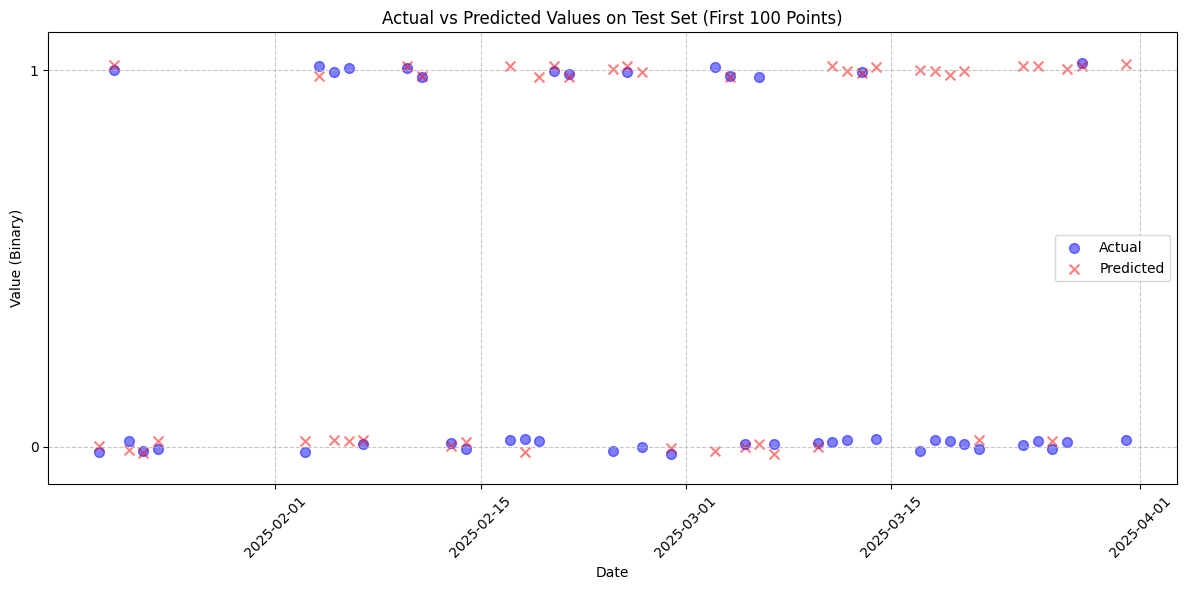

In [21]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import os

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/GRU/GRU_TRA_Classification.pth'):
    model = GRUModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    threshold = 0.6
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()

# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/GRU/GRU_TRA_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    # Plot predictions vs actual values
    plot_predictions(predictions, labels, test_dates, max_points=100)

# Run the script
if __name__ == "__main__":
    file_path = "data/TRA_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/GRU/GRU_TRA_Classification.pth')

Train IMP

In [22]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target (i + sequence_length)
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='models/GRU/GRU_IMP_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/GRU/GRU_IMP_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = GRUModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/IMP_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/GRU/GRU_IMP_Classification.pth')

Train size: 2636
Test size: 56
Class distribution in train set:
0    1577
1    1059
Name: count, dtype: int64
Class distribution in test set:
0    31
1    25
Name: count, dtype: int64
Epoch 1/100, Loss: 68.2765, Accuracy: 51.64%
Epoch 2/100, Loss: 68.1413, Accuracy: 46.19%
Epoch 3/100, Loss: 68.1086, Accuracy: 47.56%
Epoch 4/100, Loss: 68.0937, Accuracy: 47.60%
Epoch 5/100, Loss: 68.0816, Accuracy: 47.87%
Epoch 6/100, Loss: 68.0717, Accuracy: 47.71%
Epoch 7/100, Loss: 68.0634, Accuracy: 47.94%
Epoch 8/100, Loss: 68.0564, Accuracy: 48.06%
Epoch 9/100, Loss: 68.0503, Accuracy: 48.09%
Epoch 10/100, Loss: 68.0448, Accuracy: 48.06%
Epoch 11/100, Loss: 68.0398, Accuracy: 48.55%
Epoch 12/100, Loss: 68.0352, Accuracy: 48.67%
Epoch 13/100, Loss: 68.0309, Accuracy: 49.05%
Epoch 14/100, Loss: 68.0268, Accuracy: 49.20%
Epoch 15/100, Loss: 68.0226, Accuracy: 49.39%
Epoch 16/100, Loss: 68.0184, Accuracy: 49.28%
Epoch 17/100, Loss: 68.0143, Accuracy: 49.35%
Epoch 18/100, Loss: 68.0100, Accuracy: 49.3

Load IMP

Test size: 56
Class distribution in test set:
0    31
1    25
Name: count, dtype: int64
Model loaded from models/GRU/GRU_IMP_Classification.pth

Threshold: 0.45
Test Accuracy: 0.5909
Precision: 0.5294
Recall: 0.4737
F1-Score: 0.5000

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0       True
1  2025-01-21     1.0       True
2  2025-01-22     0.0      False
3  2025-01-23     0.0       True
4  2025-01-24     1.0      False
5  2025-02-03     1.0       True
6  2025-02-04     0.0       True
7  2025-02-05     1.0       True
8  2025-02-06     1.0       True
9  2025-02-07     0.0      False
10 2025-02-10     1.0      False
11 2025-02-11     0.0      False
12 2025-02-13     1.0      False
13 2025-02-14     1.0       True
14 2025-02-17     1.0      False
15 2025-02-18     0.0      False
16 2025-02-19     1.0      False
17 2025-02-20     0.0       True
18 2025-02-21     0.0      False
19 2025-02-24     0.0       True
20 2025-02-25     1.0      False
21

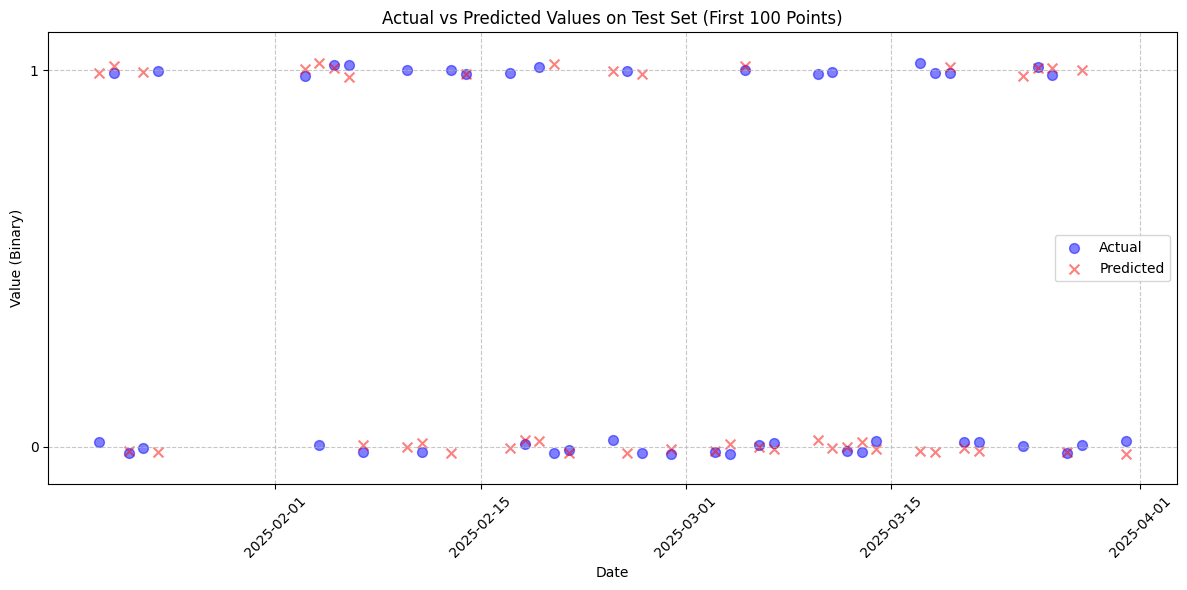

In [27]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import os

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/GRU/GRU_IMP_Classification.pth'):
    model = GRUModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    threshold = 0.45
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()

# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/GRU/GRU_IMP_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    # Plot predictions vs actual values
    plot_predictions(predictions, labels, test_dates, max_points=100)

# Run the script
if __name__ == "__main__":
    file_path = "data/IMP_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/GRU/GRU_IMP_Classification.pth')